In [95]:
# https://www.kaggle.com/code/tanyadayanand/pos-tagging-using-rnn/notebook#POS-Tagging---An-Overview

## Import package

In [96]:
import nltk
from nltk.corpus import treebank
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from nltk.probability import FreqDist
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import SimpleRNN, RNN
from keras.models import Model
import matplotlib.pyplot as plt

## Load data

In [97]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [98]:
data = list(treebank.tagged_sents(tagset='universal'))

In [99]:
data[0]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [100]:
X, y = [], []
for sentence in data:
    X_sentence = []
    y_sentence = []
    for word, tag in sentence:
        X_sentence.append(word)
        y_sentence.append(tag)
    X.append(X_sentence)
    y.append(y_sentence)
  
words, tags = X, y

## Tokenize

In [101]:
word_tokenizer, tag_tokenizer = Tokenizer(), Tokenizer()

word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

tag_tokenizer.fit_on_texts(y)
y_encoded = tag_tokenizer.texts_to_sequences(y)

## Padding sequence

In [102]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


In [103]:
X_padded = pad_sequences(X_encoded)
y_padded = pad_sequences(y_encoded)

X, y = X_padded, y_padded

In [104]:
Y = to_categorical(y)

## Split data

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,random_state=1,test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1)

## Training

In [106]:
NUM_CLASSES = Y.shape[2]
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
EMBEDDING_SIZE = 100 # heuristics?
SEQ_LENGTH = 271

In [107]:
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                    # True - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [108]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [109]:
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 271, 100)          1138800   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 271, 64)           10560     
                                                                 
 time_distributed_3 (TimeDis  (None, 271, 13)          845       
 tributed)                                                       
                                                                 
Total params: 1,150,205
Trainable params: 1,150,205
Non-trainable params: 0
_________________________________________________________________


In [110]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
25/25 [==============================] - 7s 247ms/step - loss: 1.1347 - acc: 0.8673 - val_loss: 0.5250 - val_acc: 0.9026
Epoch 2/10
25/25 [==============================] - 7s 276ms/step - loss: 0.3676 - acc: 0.9099 - val_loss: 0.3083 - val_acc: 0.9103
Epoch 3/10
25/25 [==============================] - 6s 238ms/step - loss: 0.2721 - acc: 0.9295 - val_loss: 0.2570 - val_acc: 0.9465
Epoch 4/10
25/25 [==============================] - 6s 242ms/step - loss: 0.2310 - acc: 0.9534 - val_loss: 0.2234 - val_acc: 0.9522
Epoch 5/10
25/25 [==============================] - 6s 233ms/step - loss: 0.1982 - acc: 0.9594 - val_loss: 0.1922 - val_acc: 0.9609
Epoch 6/10
25/25 [==============================] - 6s 237ms/step - loss: 0.1662 - acc: 0.9694 - val_loss: 0.1609 - val_acc: 0.9702
Epoch 7/10
25/25 [==============================] - 6s 236ms/step - loss: 0.1351 - acc: 0.9763 - val_loss: 0.1317 - val_acc: 0.9754
Epoch 8/10
25/25 [==============================] - 6s 233ms/step - loss: 0.

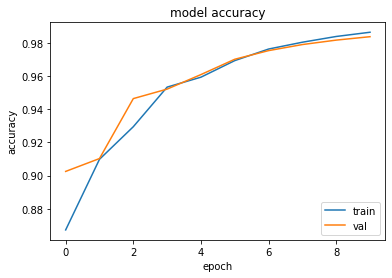

In [111]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

In [112]:
rnn_test = rnn_model.predict(X_test)

In [113]:
np.max(rnn_test, axis=2).shape

(392, 271)

In [114]:
y_pred = np.argmax(rnn_test, axis=2)
y_test = np.argmax(Y_test, axis=2)

In [115]:
accuracy = np.sum(y_pred == y_test) / len(y_pred.flatten())

In [116]:
print("Test accuracy:", accuracy)

Test accuracy: 0.9846468107538219
